### Gambling system - Martingale
In this notebook we will test the potential of using a generic Martingale scheme for consistently making profit on Roulette gambling. The aim of the notebook is to use a system that is as generic as possible, with as many hyper parameters as feasible and optimize for the profit.  
  
The idea goes as following: Rather than playing one game with potentially large losses, we play multiple smaller games with a fixed initial investment *S*. If that investment is lost, we don't fall into the sunk cost fallacy and continue to invest, but we initialize a new game with the same initial investment.  
The first bet in the game is always a fixed percentage of the initial investment, *p*. On every gamble that we lose, we increase the next bet times a pre-defined function, *f(m)*, where *m* is the number of bets lost. For the begining, this will be a constant function, e.g. *f(m)=1.90*.
The objective of one simulation in which we play *N* games is to compute the total profit (or loss) with a statistically significant margin.
References:  
[1] https://towardsdatascience.com/the-truth-about-the-martingale-betting-system-499c30467af1  
[2] https://www.roulettesites.org/strategies/martingale/

### Hyper Parameters:
n - number of gables in a game  
p - fractio of the first bet relative to the invested sum  
f(m) - multiplier of the bet after each lost round

### Game constraints:
wp - winning percentage - (18/37 = 48.64%)  
min_bet - assume £0.1  
max_bet - assume £100k  
min_p - 10^(-6)  

### Plan:
1. Create a function that simulates one game of gambles with the n, p and f(m) as hyper-parameters.
2. Verify that the by blindly following the martingale strategy without a loss threshold we would eventually run out of cash. Specifically, that means that setting a large n the game will always yield a negative return
3. Run a grid search over the space of n, p and f(m) in search of positive yields
4. Estimate the statistical variance of the positive yields.

In [1]:
# initialize hyperparameters
n = 10
p = 0.01
f = lambda x: 2.0**x

# constraints:
wp = float(18/37)
min_p = 1e-6

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def game(n,p,f):
    lost_rounds = 0 # initialize counter
    profit = 0 # initialize the profit
    profit_array = []
    
    for i in range(n):
        # record the current profit
        profit_array.append(profit)
        
        # place the current bet
        current_bet = p * f(lost_rounds)
        
        # if by placing the bet we go over threshold, then end the game with the current losses
        if (profit-current_bet < -1):
            return np.array(profit_array)
        #else continue the game
        else:
            profit = profit - current_bet

        # now run the bet
        if (np.random.rand() < wp):
            # won: profit in this round is equal to twice the current bet placed
            profit = profit + 2 * current_bet
            # re-initialize number of lost rounds in a row
            lost_rounds = 0
        else:
            lost_rounds = lost_rounds + 1
            
    return np.array(profit_array)

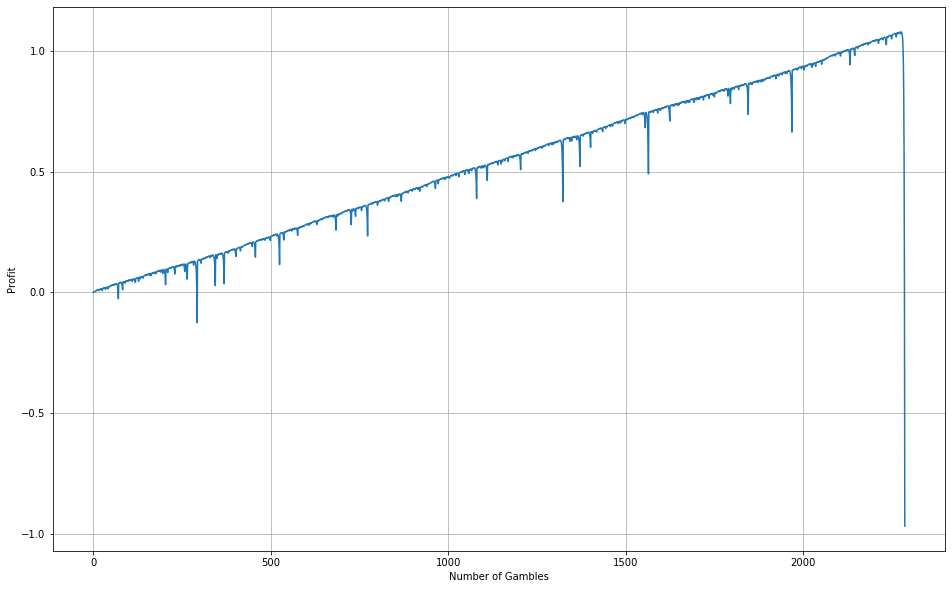

In [25]:
# 2. Verify that the function behaves as expected
np.random.seed(1)
profit_large_n = game(n=int(1e6),p=0.001,f=lambda x: 2.0**x)
plt.figure(figsize=(16,10))
plt.plot(profit_large_n)
plt.grid()
plt.xlabel('Number of Gambles')
plt.ylabel('Profit')
plt.savefig('gambling_new/verify_simple_martingale.png')

### 3. grid search over p, n and f(m)

In [5]:
def simulation(n,p,f,N=10,SEED=88):
    np.random.seed(SEED)
    profit_list = []
    for i in range(N):
        profit_in_game = game(n,p,f)
        if len(profit_in_game) > 1:
            profit_list.append(game(n,p,f)[-1])
        else:
            profit_list.append(profit_in_game)
    profit_list = np.array(profit_list)
    return {'average_profit':profit_list.mean(),'volatility':profit_list.std()}

In [6]:
n = np.arange(1, 50, 1)  
p = np.arange(5e-3, 5e-1, 5e-3)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f=lambda x: 2**x, N=100, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: -10.138938363224078


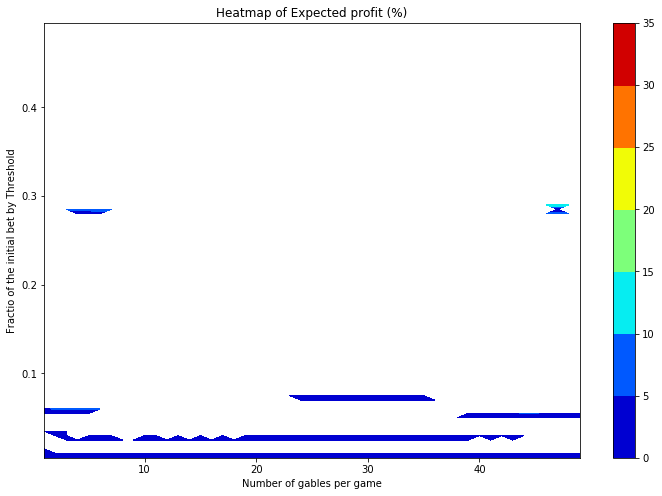

In [7]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game.png')
plt.show()

### Observations
1. The average profit yield in the area p=(0.005,0.5) and n=(1,50) is negative.
2. An pattern is formed across the y axis - lower *p*s yield consistent positive returns

### Actions
1. Survey a region of lower p values.

In [8]:
n = np.arange(1, 50, 1)  
p = np.arange(5e-5, 5e-3, 5e-5)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f=lambda x: 2**x, N=100, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: -0.7975462481962482


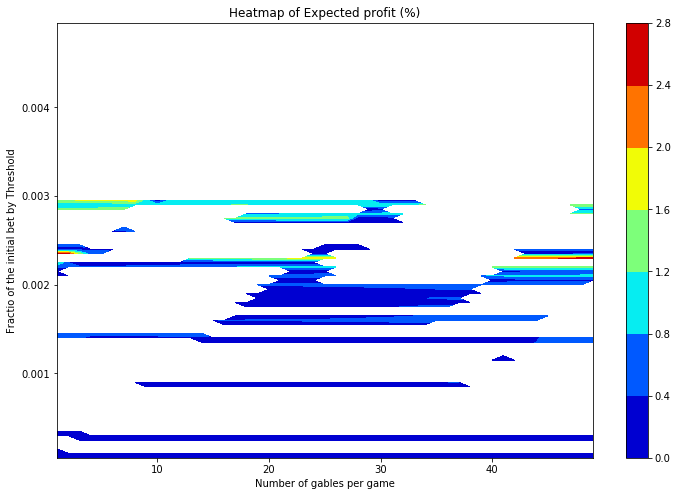

In [9]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game2.png')
plt.show()

### Observations
1. Althought the profit in the region p=(0.00005,0.005) and n=(1,50) is still negative, it increased by an order of magnitude as compared to the previous space of p=(0.005,0.5) and n=(1,50)
2. There is still a trend indicating that lower fractios lead to better outcomes.

### Actions
1. Surver a region of extremelly low p values (i.e. outside of the threshold of 1e-6 imposed by the ratio of minimum to maximum bet)

In [10]:
n = np.arange(1, 50, 1)  
p = np.arange(1e-10, 1e-8, 1e-10)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f=lambda x: 2.0**x, N=100, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: -1.4722448979591852e-06


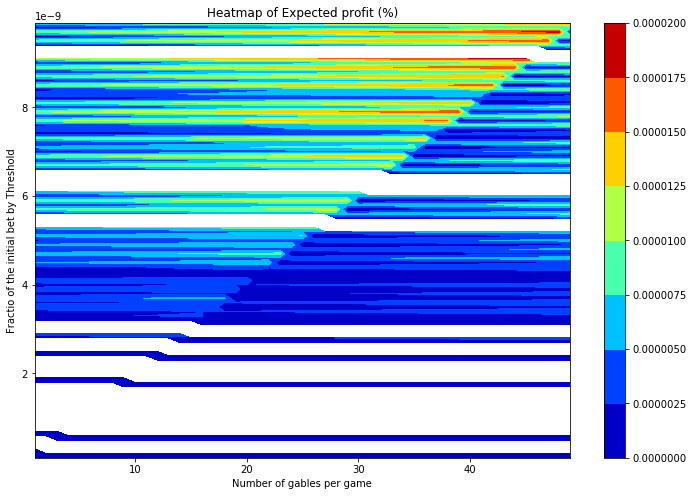

In [11]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game_smallest_p.png')
plt.show()

### Observations
1. The first area on the p vs n map that ensures positive expected profits is in the region of 1e-8. However, as shown in the plot above, there are still some localized white (negative) yields distributed uniformly on the plot.
2. Since the maximum values of p that ensures positive profits are of the order of 10^-8, we conclude that it is impossible to use the martingale strategy with f(m) = 2^m
3. There is a correlation between the number of games played (n) and the fractio of the initial bet (p). Again, no free lunch: if you cannot afford lower p, you would have to play for longer.


### Actions
1. Surver a region of extremelly large n.
2. Try using with different multiplication functions f(m)

#### Action 1

In [12]:
n = np.arange(50, 500, 10)  
p = np.arange(1e-9, 1e-7, 1e-9)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f=lambda x: 2.0**x, N=10, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: 0.0006241333333333332


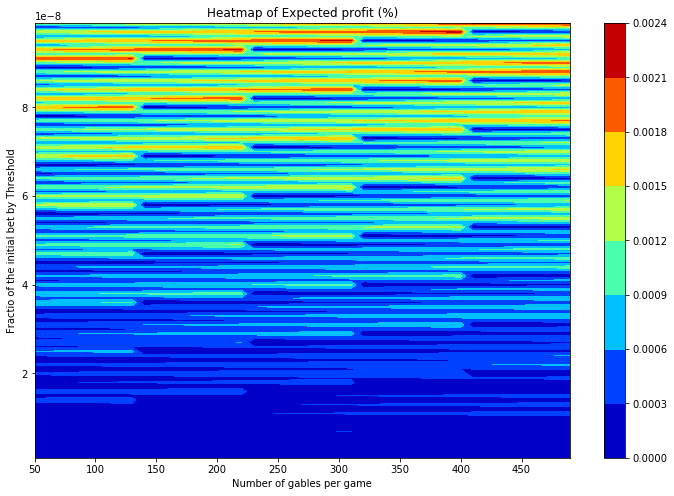

In [13]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game_smallest_p_large_n.png')
plt.show()

In [14]:
n = np.arange(50, 500, 10)  
p = np.arange(1e-7, 1e-5, 1e-7)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f=lambda x: 2.0**x, N=10, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: -1.6134086841750839


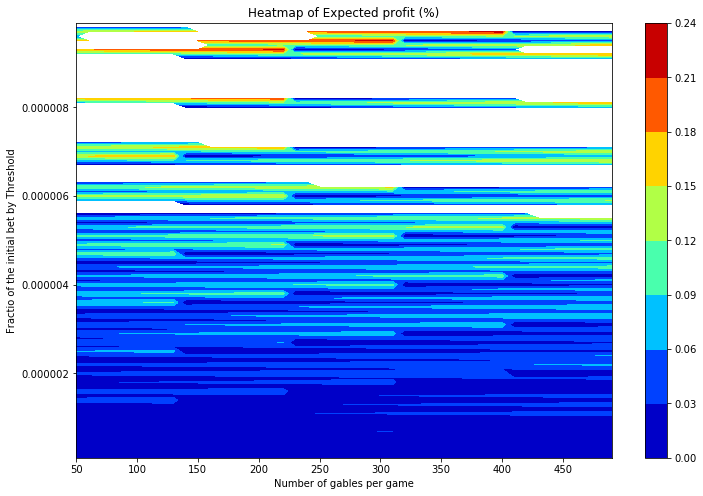

In [15]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game_large_n.png')
plt.show()

#### Action 2

In [16]:
# let us try a multiplication function that drops with the number of gambles lost
def f(m, gamma=0.1, multiplier = 1.5):
    if m == 0: return 1.
    elif m > 0: return np.cumprod([multiplier+np.exp(-gamma*i) for i in range(m)])[-1]
    else: raise ValueError('function only accepts positive entrie whereas m={}'.format(m))

In [31]:
i = 100
f(i+1)/f(i)

1.5000453999297625

In [22]:
n = np.arange(1, 50, 1)  
p = np.arange(1e-9, 1e-7, 1e-9)  
z = []
for n_ in n:
    for p_ in p:
        z.append(simulation(n_,p_,f, N=100, SEED=88)['average_profit'])
z = np.array(z).reshape((len(p),len(n)))
z = 100 * z
print('average gains: {}'.format(z.mean()))

average gains: -0.0004873996063973609


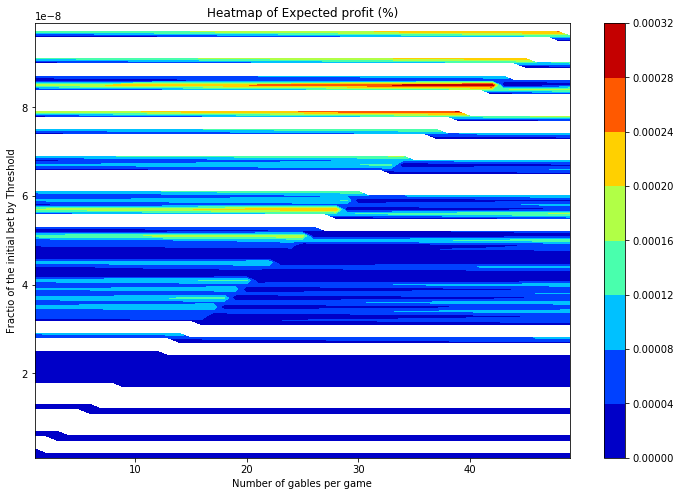

In [24]:
plt.figure(figsize=(12,8))
z_masked = np.ma.masked_where(z<0,z)
h = plt.contourf(n,p,z_masked,cmap = 'jet')
plt.colorbar()
plt.xlabel('Number of gables per game')
plt.ylabel('Fractio of the initial bet by Threshold')
plt.title('Heatmap of Expected profit (%)')
plt.savefig('gambling_new/gambling_game_varying_f.png')
plt.show()

### Conclusions
1. There does not seem to be any free lunch around the martingale system as a betting strategy for roulette. If the constraints on the minimum and maximum bet are in place, the house will continue to win you over
